# Transfer learing with ibug mask


In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Predict Ibug-mask helper function

In [70]:
import torch
import glob
import cv2
import numpy as np
import os
import torchvision.transforms as T
import random

#Resize images (height  = X, width = Y)
SIZE_X = 256 
SIZE_Y = 256

rgb_vals = [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]
#rgb_vals = [ 0,  1,  2,  3,  4,  5,  6 , 7,  8,  9, 10, 11, 12, 13, 14, 15, 16 ,17 ,18 ,19, 20]

"""IMG"""
#Capture training image info as a list
train_images = []
count = 0
#for img_path in sorted(glob.glob(os.path.join("/content/drive/MyDrive/helenstar_release/test/", "*image.jpg"))):
for img_path in sorted(glob.glob(os.path.join("/content/drive/MyDrive/helen_deeplab_no_aug_out/", "*img.png"))):
    count += 1
    #Process images
    img = cv2.imread(img_path)
    img = cv2.resize(img, (SIZE_Y, SIZE_X))
    # convert to gray
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # blur
    #smooth = cv2.GaussianBlur(gray, (95,95), 0)

    # divide gray by morphology image
    
    #division = cv2.divide(gray, smooth, scale=192)
    train_images.append(gray)

    print(count)



"""MASK"""
#Capture mask/label info as a list
train_masks = [] 
count=0
#for mask_path in sorted(glob.glob(os.path.join("/content/drive/MyDrive/helenstar_release/test/", "*label.png"))):
for mask_path in sorted(glob.glob(os.path.join("/content/drive/MyDrive/helen_deeplab_no_aug_out/", "*seg.png"))):
    count += 1
    #Process images
    mask = cv2.imread(mask_path, 0)    
    mask = cv2.resize(mask, (SIZE_Y, SIZE_X))
    train_masks.append(mask)
    print(count)

#shuffle
c = list(zip(train_images, train_masks))
random.shuffle(c)
train_images, train_masks = zip(*c)

# Conver to Torch Tensor
train_images = torch.tensor(train_images)
train_masks = torch.tensor(train_masks)

#Use customary x_train and y_train variables
X = train_images
Y = train_masks

print(X.shape)
print(Y.shape)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
torch.Size([100, 256, 256])
torch.Size([100, 256, 256])


In [71]:
num_classes = 11

In [72]:
import torchvision.transforms as T
import torchvision.transforms.functional as F
import random

def augment(x,y):
    if 0 ==1:
      # rotate XY
      r = random.randint(0,180)
      x = F.rotate(x, r)
      y = F.rotate(y, r)

    #conversion to grayscale X
    x = T.Grayscale()(x)
    
    return x,y

In [73]:
one_hot_Y = torch.nn.functional.one_hot(Y.to(torch.int64), num_classes)
print(one_hot_Y.shape)
"""
X = X.permute(0, 3, 1, 2).float()
one_hot_Y = one_hot_Y.permute(0, 3, 1, 2).float()

augmented_X = []
augmented_Y = []

for x in range(len(X)):
  # Apply same augmentation to X,Y as pack
  pack = augment(X[x], one_hot_Y[x])
  augmented_X.append(pack[0])
  augmented_Y.append(pack[1])
  """

X = X.unsqueeze(1).float()
Y = one_hot_Y.permute(0, 3, 1, 2).float()
print(X.shape)
print(Y.shape)

torch.Size([100, 256, 256, 11])
torch.Size([100, 1, 256, 256])
torch.Size([100, 11, 256, 256])


In [74]:
"""X = torch.stack(augmented_X)
Y = torch.stack(augmented_Y)

print(X.shape)
print(Y.shape)"""

'X = torch.stack(augmented_X)\nY = torch.stack(augmented_Y)\n\nprint(X.shape)\nprint(Y.shape)'

In [75]:
import matplotlib.pyplot as plt

# Helper functions from "https://github.com/HardevKhandhar/building-segmentation-image-processing/blob/main/geospatial_buildings.ipynb"

# helper function for data visualization
def visualize(**images):
    """
    Plot images in one row
    """
    n_images = len(images)
    plt.figure(figsize=(20,8))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([]); 
        plt.yticks([])
        # get title from the parameter names
        plt.title(name.replace('_',' ').title(), fontsize=20)
        plt.imshow(image)
    plt.show()

def reverse_one_hot(image):
    """
    Transform a 2D array in one-hot format (depth is num_classes),
    to a 2D array with only 1 channel, where each pixel value is
    the classified class key.
    # Arguments
        image: The one-hot format image 
        
    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of 1, where each pixel value is the classified 
        class key.
    """
    #argmax returns the indices of the maximum values along an axis. 
    x = np.argmax(image, axis = -3)
    return x

# Perform colour coding on the reverse-one-hot outputs
def colour_code_segmentation(image, label_values):
    """
    Given a 1-channel array of class keys, colour code the segmentation results.
    # Arguments
        image: single channel array where each value represents the class key.
        label_values

    # Returns
        Colour coded image for segmentation visualization
    """
    colour_codes = np.array(label_values)
    #print(colour_codes)
    x = colour_codes[image.numpy().astype(int)]

    return x

In [76]:
! pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [77]:
from sklearn.metrics import jaccard_score, f1_score
import tensorflow as tf
from torchmetrics.classification import F1Score, BinaryF1Score, MulticlassF1Score,MultilabelF1Score
from sklearn.preprocessing import MultiLabelBinarizer
from torchvision.utils import save_image
from PIL import Image
from sklearn.metrics import confusion_matrix

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def average(lst):
    return sum(lst) / len(lst)

def view_predictions(model, ds, numm_classes, save=False):

    ious = []
    f1s = []

    gts = []
    preds = []

    #predict
    for idx in range(len(ds)):

        image, gt_mask = ds[idx]
        image_vis = ds[idx][0]
        image_vis = np.transpose(image_vis,(1,2,0))
        #print(image_vis.shape)
        
        x_tensor = image.to(DEVICE).unsqueeze(0)
        # Predict test image
        pred_mask = model(x_tensor).detach().cpu().numpy()
        gt_mask=gt_mask.unsqueeze(0)
        #print("predshape",pred_mask.shape)
        #print("gtshape",gt_mask.shape)


        metric = MultilabelF1Score(num_labels=11, average=None, labels=np.unique(pred_mask))
        f1 = metric(torch.tensor(pred_mask), torch.tensor(gt_mask))
        if len(f1) == 11:
          f1s.append(np.array(f1))

        #pred_mask = pred_mask.detach().squeeze().cpu().numpy()
        # Convert pred_mask from `CHW` format to `HWC` format
        #print(pred_mask.shape)

       # print(rgb_vals)
        # Get prediction channel corresponding to face
        pred_mask = colour_code_segmentation(reverse_one_hot(torch.tensor(pred_mask)), rgb_vals)
        #print(pred_mask.shape)
        
        # Convert gt_mask from `CHW` format to `HWC` format
        #print(gt_mask.shape)
        gt_mask = colour_code_segmentation(reverse_one_hot(torch.tensor(gt_mask)), rgb_vals)
        
        #get IoU score
        #m = tf.keras.metrics.MeanIoU(num_classes=numm_classes)
        #m.update_state(gt_mask, pred_mask)
        #iou = m.result().numpy()
        #print("MEAN IoU:" , iou)
        #ious.append(iou)

        #Get f1
        #m = MultiLabelBinarizer().fit(gt_mask)
        #f1 = f1_score(m.transform(gt_mask), m.transform(pred_mask), average=None)
        #if len(f1) == 11:
        #  f1s.append(f1)
        #print("predshape",pred_mask.shape)
        #("gtshape",gt_mask.shape)

        if [idx][0] < 5:
          print(f1)
          visualize(
              original_image = image_vis[:,:,0],
              ground_truth_mask = gt_mask[0,:,:,],
              predicted_mask = pred_mask[0,:,:,],
          )

        gts.append(gt_mask)
        preds.append(pred_mask)

        if save == True:
          # Save Predictions for use in Label Adapter
          im = Image.fromarray(pred_mask.squeeze(0).astype(np.uint8))
          im.save("/content/drive/MyDrive/helen_deeplab_no_aug_out/" + str(idx) + "_img.png")

          im2 = Image.fromarray(gt_mask.squeeze(0).astype(np.uint8))
          im2.save("/content/drive/MyDrive/helen_deeplab_no_aug_out/" + str(idx) + "_seg.png")
    
    fs1_numpy = np.array(f1s)
   # print(fs1_numpy.type())
    av_f1s = np.average(fs1_numpy, axis=0, weights=(fs1_numpy > 0))
    av_f1s_av = av_f1s.mean(axis=0)

    print ("Dataset F1 = ", av_f1s)
    print ("Dataset F1 av = ", av_f1s_av)

    #confusion_matrix(gts,preds)

In [78]:
! pip install segmentation-models-pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [79]:
import segmentation_models_pytorch as smp

In [80]:
class Ibug_DS(torch.utils.data.Dataset):
  def __init__(self, x, y):
    super(Ibug_DS, self).__init__()
    
    # store the augmented tensors tensors
    self._x, self._y = x,y

  def __len__(self):
    # a DataSet must know it size
    return self._x.shape[0]

  def __getitem__(self, index):
    x = self._x[index, :]
    y = self._y[index, :]
    # print("GETTING ITEM")
    return x, y

ibug_ds = Ibug_DS(X, Y)

0: background
1: facial skin
2: left brow (viewer side)
3: right brow
4: left eye
5: right eye
6: nose
7: upper lip
8: inner mouth
9: lower lip
10: hair

### Deeplabv3+ with iBugMask

*   List item
*   List item



model loaded
predshape (1, 11, 256, 256)
gtshape torch.Size([1, 11, 256, 256])
predshape (1, 256, 256)
gtshape (1, 256, 256)
tensor([0.9946, 0.8718, 0.4094, 0.4597, 0.5000, 0.2432, 0.8845, 0.6410, 0.0000,
        0.4196, 0.7465])


<ipython-input-77-30d6a403839c>:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  f1 = metric(torch.tensor(pred_mask), torch.tensor(gt_mask))
<ipython-input-77-30d6a403839c>:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gt_mask = colour_code_segmentation(reverse_one_hot(torch.tensor(gt_mask)), rgb_vals)


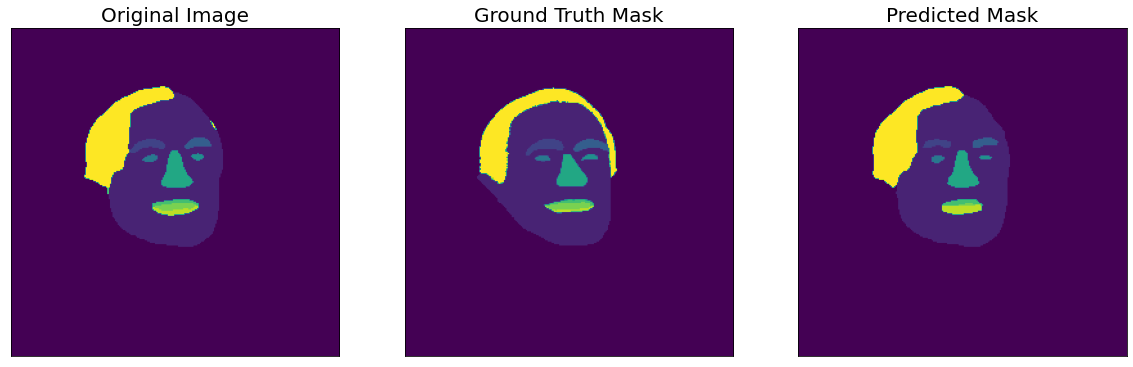

predshape (1, 11, 256, 256)
gtshape torch.Size([1, 11, 256, 256])
predshape (1, 256, 256)
gtshape (1, 256, 256)
tensor([0.9442, 0.9427, 0.5693, 0.4688, 0.1277, 0.1739, 0.8452, 0.3887, 0.2505,
        0.5679, 0.8263])


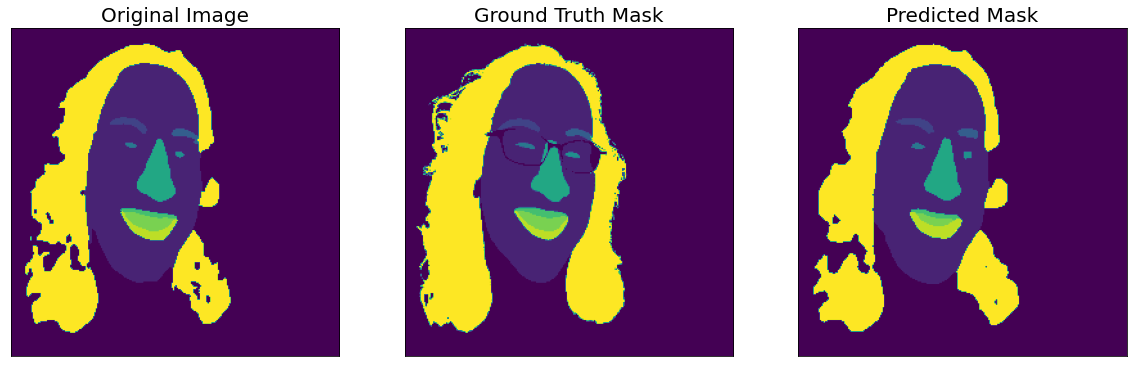

predshape (1, 11, 256, 256)
gtshape torch.Size([1, 11, 256, 256])
predshape (1, 256, 256)
gtshape (1, 256, 256)
tensor([0.9846, 0.9206, 0.0000, 0.0000, 0.0000, 0.0000, 0.4627, 0.0765, 0.0000,
        0.5830, 0.9029])


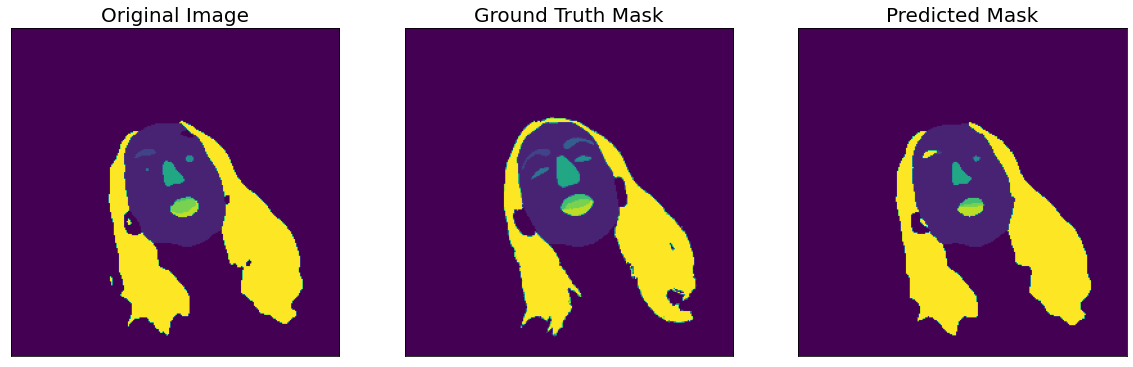

predshape (1, 11, 256, 256)
gtshape torch.Size([1, 11, 256, 256])
predshape (1, 256, 256)
gtshape (1, 256, 256)
tensor([0.9921, 0.9267, 0.3647, 0.5449, 0.5227, 0.5526, 0.8988, 0.1071, 0.0000,
        0.7970, 0.7384])


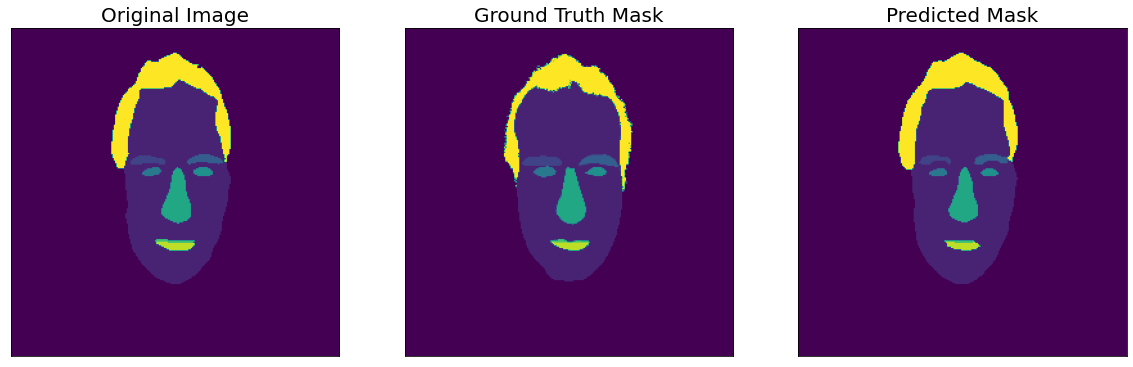

predshape (1, 11, 256, 256)
gtshape torch.Size([1, 11, 256, 256])
predshape (1, 256, 256)
gtshape (1, 256, 256)
tensor([0.9929, 0.9173, 0.2700, 0.5178, 0.3333, 0.0211, 0.8678, 0.0000, 0.0000,
        0.4623, 0.9033])


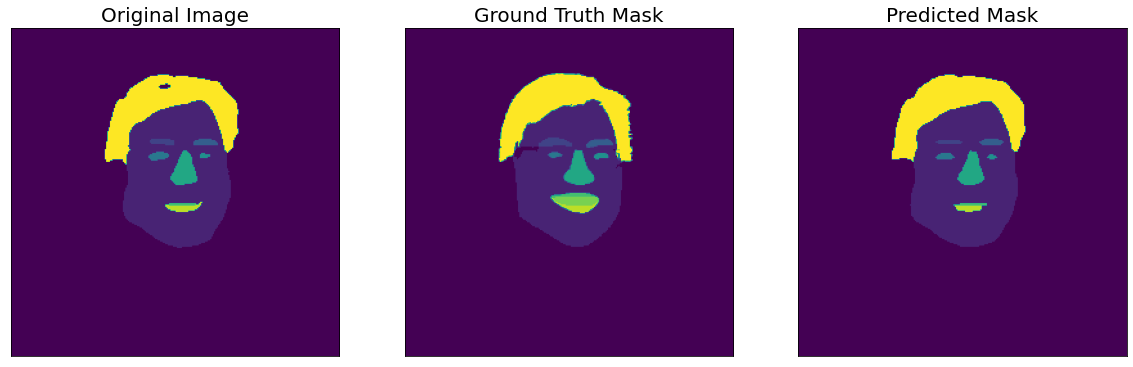

predshape (1, 11, 256, 256)
gtshape torch.Size([1, 11, 256, 256])
predshape (1, 256, 256)
gtshape (1, 256, 256)
predshape (1, 11, 256, 256)
gtshape torch.Size([1, 11, 256, 256])
predshape (1, 256, 256)
gtshape (1, 256, 256)
predshape (1, 11, 256, 256)
gtshape torch.Size([1, 11, 256, 256])
predshape (1, 256, 256)
gtshape (1, 256, 256)
predshape (1, 11, 256, 256)
gtshape torch.Size([1, 11, 256, 256])
predshape (1, 256, 256)
gtshape (1, 256, 256)
predshape (1, 11, 256, 256)
gtshape torch.Size([1, 11, 256, 256])
predshape (1, 256, 256)
gtshape (1, 256, 256)
predshape (1, 11, 256, 256)
gtshape torch.Size([1, 11, 256, 256])
predshape (1, 256, 256)
gtshape (1, 256, 256)
predshape (1, 11, 256, 256)
gtshape torch.Size([1, 11, 256, 256])
predshape (1, 256, 256)
gtshape (1, 256, 256)
predshape (1, 11, 256, 256)
gtshape torch.Size([1, 11, 256, 256])
predshape (1, 256, 256)
gtshape (1, 256, 256)
predshape (1, 11, 256, 256)
gtshape torch.Size([1, 11, 256, 256])
predshape (1, 256, 256)
gtshape (1, 25

In [81]:
model = torch.load('/content/drive/MyDrive/label_adapter_helen_deeplab_no_aug.pth', map_location=DEVICE)
print("model loaded")

view_predictions(model, ibug_ds, 11, save=False)